## Importing the Libraries:

In [23]:
import pandas as pd
import gensim
from gensim import corpora, models
from gensim.models import CoherenceModel
import ast
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
from nltk.corpus import stopwords
import itertools

## Loading the Pre-processed (Lemmatized) Data:

In [2]:
lemmatized_text_data = pd.read_csv(r"C:\Users\Utkarsh\Desktop\Amazon_comments_processed.csv")
lemmatized_text_data = lemmatized_text_data.iloc[:, 1:]
lemmatized_text_data

,Title_Review,Stars,Company_name,Recommend,CEO_approval,Business_outlook,Pros,Cons,Employee_seniority,Location,Date,id
0,"['good', 'impression', 'first', 'month']",5.0,['amazon'],['positive'],['neutral'],['neutral'],"['documentation', 'amazon', 'super', 'importan...","['need', 'understand', 'job', 'need', 'improve...","['current', 'employee', 'less', '1', 'year']",['toronto'],"['feb.', '2', '2023']",empReview_73247758
1,['intern'],5.0,['amazon'],['neutral'],['neutral'],['neutral'],"['4', 'day', 'shifts', 'nice']","['long', 'hour', 'shift', 'make', 'feel', 'tire']","['former', 'employee', 'less', '1', 'year']",['toronto'],"['jan.', '31', '2023']",empReview_73187609
2,['good'],5.0,['amazon'],['positive'],['positive'],['positive'],"['great', 'work', 'balance', 'great', 'environ...","['workload', 'heavy', 'sometimes']","['former', 'employee', '1', 'year']","['amazon', 'sk']","['jan.', '31', '2023']",empReview_73188818
3,"['job', 'review']",5.0,['amazon'],['positive'],['positive'],['positive'],"['good', 'benefit', 'flexible', 'time', 'shift...","['good', 'organization', 'work', 'well', 'car'...","['former', 'employee']",['nan'],"['jan.', '31', '2023']",empReview_73190433
4,"['growth', 'opportunity']",4.0,['amazon'],['positive'],['negative'],['negative'],"['fast', 'paced', 'start-up', 'culture', 'bene...","['compensation', 'growth', 'prospect', 'develo...","['current', 'employee', '3', 'year']","['vancouver', 'bc']","['jan.', '31', '2023']",empReview_73197210
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,"['great', 'pay', 'onboarding']",5.0,['amazon'],['positive'],['positive'],['positive'],"['amazon', 'wonderful', 'search', 'site', 'fin...","['interview', 'process', 'long', 'worth', 'end']","['current', 'employee', 'less', '1', 'year']",['nan'],"['dec.', '1', '2022']",empReview_71536795
9996,"['great', 'comp']",5.0,['amazon'],['neutral'],['neutral'],['neutral'],"['great', 'company', 'easy', 'find', 'area', '...","['get', 'unlucky', 'team']","['current', 'employee']",['nan'],"['dec.', '1', '2022']",empReview_71537065
9997,"['far', 'good']",5.0,['amazon'],['positive'],['positive'],['positive'],"['great', 'teamwork', 'great', 'work', 'enviro...","['little', 'far', 'home']","['current', 'employee', 'less', '1', 'year']","['querétaro', 'querétaro']","['dec.', '1', '2022']",empReview_71539933
9998,"['use', 'great', 'company']",2.0,['amazon'],['negative'],['negative'],['negative'],"['become', 'excellent', 'problem', 'solver', '...","['cut-throat', 'management', 'toxic', 'culture...","['former', 'employee', '1', 'year']","['diego', 'ca']","['dec.', '15', '2022']",empReview_71882994


In [3]:
df = lemmatized_text_data[['id', 'Employee_seniority', 'Pros', 'Cons']]
df['current_employee'] = df['Employee_seniority'].apply(lambda x: 'current' in x).astype(int)
df = df[['id', 'current_employee', 'Pros', 'Cons']]
df['Pros'] = df['Pros'].apply(ast.literal_eval)
df['Cons'] = df['Cons'].apply(ast.literal_eval)
df

C:\Users\Utkarsh\AppData\Local\Temp\ipykernel_5604\1187017345.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['current_employee'] = df['Employee_seniority'].apply(lambda x: 'current' in x).astype(int)


,id,current_employee,Pros,Cons
0,empReview_73247758,1,"[documentation, amazon, super, important, poin...","[need, understand, job, need, improve, good, d..."
1,empReview_73187609,0,"[4, day, shifts, nice]","[long, hour, shift, make, feel, tire]"
2,empReview_73188818,0,"[great, work, balance, great, environment, loc...","[workload, heavy, sometimes]"
3,empReview_73190433,0,"[good, benefit, flexible, time, shift, take, c...","[good, organization, work, well, car, parking,..."
4,empReview_73197210,1,"[fast, paced, start-up, culture, benefit]","[compensation, growth, prospect, development, ..."
...,...,...,...,...
9995,empReview_71536795,1,"[amazon, wonderful, search, site, find, anythi...","[interview, process, long, worth, end]"
9996,empReview_71537065,1,"[great, company, easy, find, area, like]","[get, unlucky, team]"
9997,empReview_71539933,1,"[great, teamwork, great, work, environment, pe...","[little, far, home]"
9998,empReview_71882994,0,"[become, excellent, problem, solver, use, data...","[cut-throat, management, toxic, culture, unnec..."


## Performing Topic Modelling on the Pros and Cons From Each Review:

### Pros:

**In this section we will evaluate the degree to which the words in the 'Pros' column are semantically related and form a coherent meaning.**

We will do this by calculating the topic coherence score for different numbers of topics and choosing the one results in the highest score.

In [4]:
# Prepare Dictionary
data_ready_pros = df['Pros'].tolist()
id2word = corpora.Dictionary(data_ready_pros)
corpus_pros = [id2word.doc2bow(text) for text in data_ready_pros]

In [5]:
# Building model
num_topics = [i+1 for i in range(8)]
num_keywords = 20

LDA_models = {}
LDA_topics = {}
for i in tqdm(num_topics):
    LDA_models[i] = gensim.models.ldamodel.LdaModel(corpus=corpus_pros,
                                                    id2word=id2word,
                                                    num_topics=i,
                                                    update_every=1,
                                                    chunksize=10,
                                                    passes=20,
                                                    alpha='asymmetric',
                                                    random_state=100)

    shown_topics = LDA_models[i].show_topics(num_topics=i, 
                                             num_words=num_keywords,
                                             formatted=False)
    LDA_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [12:03<00:00, 90.44s/it]


In [6]:
coherences = []
for i in tqdm(num_topics):
    coherences.append(gensim.models.CoherenceModel(model=LDA_models[i], texts=data_ready_pros, dictionary=id2word, coherence='c_v').get_coherence())

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:12<00:00,  9.04s/it]


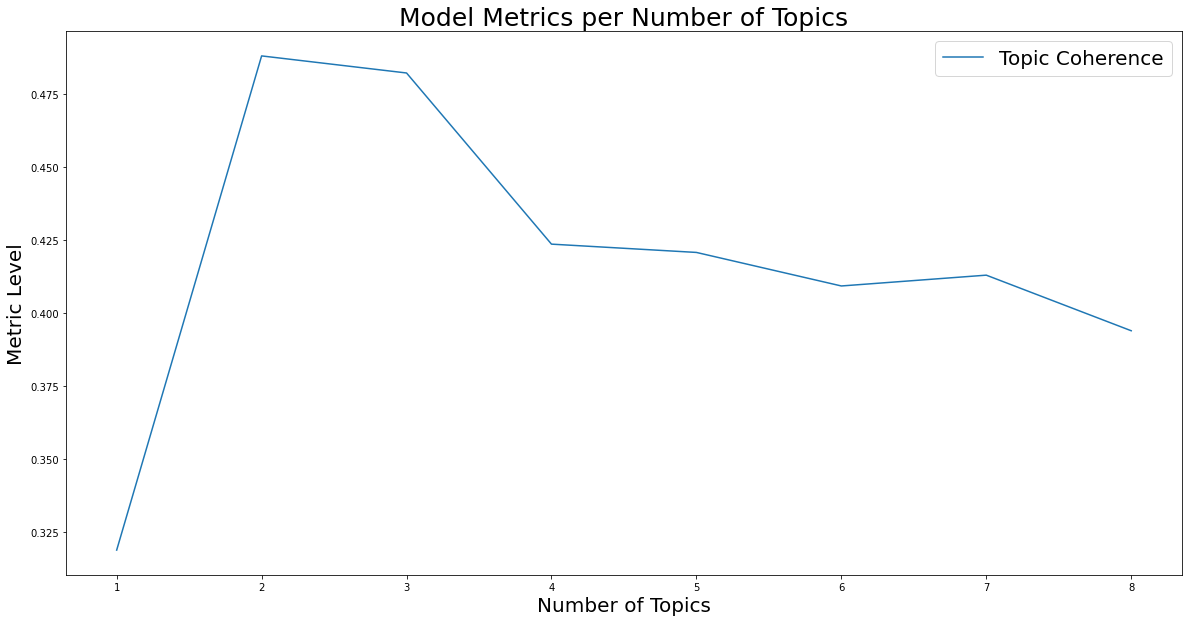

In [7]:
# Visualizing results
plt.figure(figsize=(20,10))
ax = sns.lineplot(x=num_topics, y=coherences, label='Topic Coherence')
ax.axes.set_title('Model Metrics per Number of Topics', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
plt.legend(fontsize=20)
plt.show()

In [8]:
def format_topics_sentences(ldamodel, corpus, texts):
    sent_topics_df = pd.DataFrame()

    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            

        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [9]:
n_topics_pros = 2
lda_model_pros = LDA_models[n_topics_pros]

In [10]:
df_topic_pros_keywords = format_topics_sentences(ldamodel=lda_model_pros, corpus=corpus_pros, texts=data_ready_pros)

# Format
df_dominant_topic = df_topic_pros_keywords.reset_index()
df_dominant_topic.columns = ['Review_ID', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

C:\Users\Utkarsh\AppData\Local\Temp\ipykernel_5604\2700792715.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
C:\Users\Utkarsh\AppData\Local\Temp\ipykernel_5604\2700792715.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


In [11]:
df_dominant_topic['Review_ID'] = df['id']
df_dominant_topic.head(10)

,Review_ID,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,empReview_73247758,1,0.8816,"opportunity, learn, amazon, lot, growth, work,...","[documentation, amazon, super, important, poin..."
1,empReview_73187609,0,0.9250,"good, work, great, pay, benefit, time, job, en...","[4, day, shifts, nice]"
2,empReview_73188818,0,0.8313,"good, work, great, pay, benefit, time, job, en...","[great, work, balance, great, environment, loc..."
3,empReview_73190433,0,0.6971,"good, work, great, pay, benefit, time, job, en...","[good, benefit, flexible, time, shift, take, c..."
4,empReview_73197210,0,0.9292,"good, work, great, pay, benefit, time, job, en...","[fast, paced, start-up, culture, benefit]"
5,empReview_73208298,1,0.7689,"opportunity, learn, amazon, lot, growth, work,...","[opportunity, grow, work, talented, people]"
6,empReview_73149307,1,0.8495,"opportunity, learn, amazon, lot, growth, work,...","[lot, challenge, speak, data, great, leadership]"
7,empReview_73146117,0,0.7682,"good, work, great, pay, benefit, time, job, en...","[good, pay, benefit, new, grad]"
8,empReview_73105526,0,0.9354,"good, work, great, pay, benefit, time, job, en...","[pay, rate, good, accord, work]"
9,empReview_73108472,0,0.7679,"good, work, great, pay, benefit, time, job, en...","[great, benefit, bonus, everything, available,..."


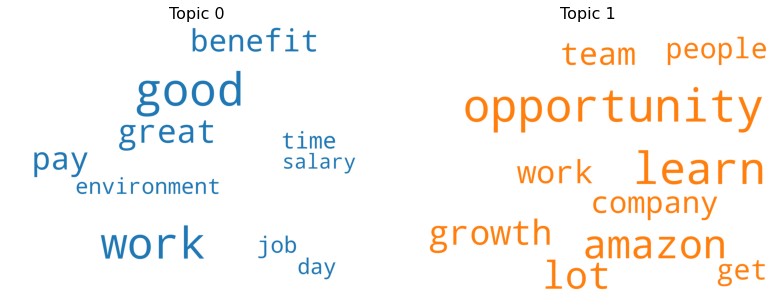

In [13]:
stop_words = set(stopwords.words('english'))
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model_pros.show_topics(formatted=False)

fig, axes = plt.subplots(1, 2, figsize=(11,11), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

**Our process resulted in two being the optimal number of topics for the ‘Pros’ column. One of the topics highlighted the pay grade and benefits as the pros of working at Amazon (Topic 0). The other topic highlighted the opportunity to learn and grow as the pros of working at Amazon (Topic 1).**

------------------------------------------------------------------------------

### Cons:

**In this section we will evaluate the degree to which the words in the 'Cons' column are semantically related and form a coherent meaning.**

We will do this by once again calculating the topic coherence score for different numbers of topics and choosing the one results in the highest score.

In [14]:
# Prepare Dictionary
data_ready_cons = df['Cons'].tolist()
id2word = corpora.Dictionary(data_ready_cons)
corpus_cons = [id2word.doc2bow(text) for text in data_ready_cons]

In [15]:
# Building model
num_topics = [i+1 for i in range(8)]
num_keywords = 20

LDA_models = {}
LDA_topics = {}
for i in tqdm(num_topics):
    LDA_models[i] = gensim.models.ldamodel.LdaModel(corpus=corpus_cons,
                                                    id2word=id2word,
                                                    num_topics=i,
                                                    update_every=1,
                                                    chunksize=10,
                                                    passes=20,
                                                    alpha='asymmetric',
                                                    random_state=100)

    shown_topics = LDA_models[i].show_topics(num_topics=i, 
                                             num_words=num_keywords,
                                             formatted=False)
    LDA_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]

100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [14:31<00:00, 108.88s/it]


In [16]:
coherences = []
for i in tqdm(num_topics):
    coherences.append(gensim.models.CoherenceModel(model=LDA_models[i], texts=data_ready_cons, dictionary=id2word, coherence='c_v').get_coherence())

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:06<00:00,  8.37s/it]


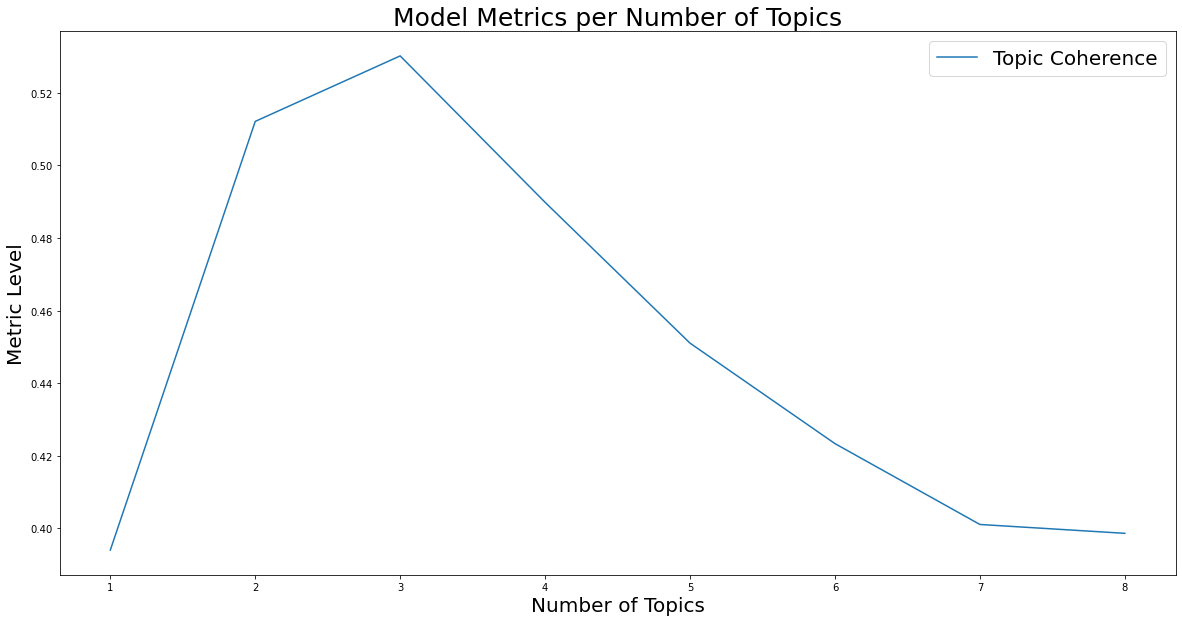

In [17]:
# Visualizing results
plt.figure(figsize=(20,10))
ax = sns.lineplot(x=num_topics, y=coherences, label='Topic Coherence')
ax.axes.set_title('Model Metrics per Number of Topics', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
plt.legend(fontsize=20)
plt.show()

In [18]:
n_topics_cons = 3
lda_model_cons = LDA_models[n_topics_cons]

In [19]:
df_topic_cons_keywords = format_topics_sentences(ldamodel=lda_model_cons, corpus=corpus_cons, texts=data_ready_cons)

# Format
df_dominant_topic_cons = df_topic_cons_keywords.reset_index()
df_dominant_topic_cons.columns = ['Review_ID', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

C:\Users\Utkarsh\AppData\Local\Temp\ipykernel_5604\2700792715.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
C:\Users\Utkarsh\AppData\Local\Temp\ipykernel_5604\2700792715.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


In [20]:
df_dominant_topic_cons['Review_ID'] = df['id']
df_dominant_topic_cons.head(10)

,Review_ID,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,empReview_73247758,2,0.6520,"n't, con, job, manager, amazon, employee, like...","[need, understand, job, need, improve, good, d..."
1,empReview_73187609,0,0.6398,"work, hour, time, long, lot, day, shift, much,...","[long, hour, shift, make, feel, tire]"
2,empReview_73188818,0,0.8691,"work, hour, time, long, lot, day, shift, much,...","[workload, heavy, sometimes]"
3,empReview_73190433,1,0.4363,"get, bad, pay, balance, good, culture, life, t...","[good, organization, work, well, car, parking,..."
4,empReview_73197210,1,0.8770,"get, bad, pay, balance, good, culture, life, t...","[compensation, growth, prospect, development, ..."
5,empReview_73208298,0,0.5003,"work, hour, time, long, lot, day, shift, much,...","[potential, layoff, fast, pace]"
6,empReview_73149307,1,0.4016,"get, bad, pay, balance, good, culture, life, t...","[none, best, company, ever, glad, worked]"
7,empReview_73146117,0,0.8953,"work, hour, time, long, lot, day, shift, much,...","[lot, work, high, stress]"
8,empReview_73105526,0,0.4953,"work, hour, time, long, lot, day, shift, much,...","[much, stress, give, employee]"
9,empReview_73108472,0,0.5310,"work, hour, time, long, lot, day, shift, much,...","[work, culture, negative, depend, location, li..."


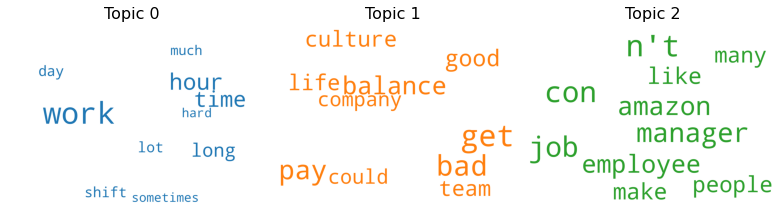

In [21]:
stop_words = set(stopwords.words('english'))
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model_cons.show_topics(formatted=False)

fig, axes = plt.subplots(1, 3, figsize=(11,11), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

**Our process resulted in three being the optimal number of topics for the ‘Cons’ column. One of the topics highlighted the long working times as the cons of working at Amazon (Topic 0). Another topic highlighted the bad culture and pay-grade as the cons of working at Amazon (Topic 1). The last topic highlighted managers and other fellow employees as the cons of working at Amazon (Topic 2).**

## Results:

In [22]:
df_pros_cons = df[["id", "current_employee"]]

df_pros_cons["Pros_Dominant_Topic"] = df_dominant_topic["Dominant_Topic"]
df_pros_cons["Pros_Topic_Perc_Contrib"] = df_dominant_topic["Topic_Perc_Contrib"]
df_pros_cons["Pros_Keywords"] = df_dominant_topic["Keywords"]

df_pros_cons["Cons_Dominant_Topic"] = df_dominant_topic_cons["Dominant_Topic"]
df_pros_cons["Cons_Topic_Perc_Contrib"] = df_dominant_topic_cons["Topic_Perc_Contrib"]
df_pros_cons["Cons_Keywords"] = df_dominant_topic_cons["Keywords"]

df_pros_cons

C:\Users\Utkarsh\AppData\Local\Temp\ipykernel_5604\977120469.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pros_cons["Pros_Dominant_Topic"] = df_dominant_topic["Dominant_Topic"]


,id,current_employee,Pros_Dominant_Topic,Pros_Topic_Perc_Contrib,Pros_Keywords,Cons_Dominant_Topic,Cons_Topic_Perc_Contrib,Cons_Keywords
0,empReview_73247758,1,1,0.8816,"opportunity, learn, amazon, lot, growth, work,...",2,0.6520,"n't, con, job, manager, amazon, employee, like..."
1,empReview_73187609,0,0,0.9250,"good, work, great, pay, benefit, time, job, en...",0,0.6398,"work, hour, time, long, lot, day, shift, much,..."
2,empReview_73188818,0,0,0.8313,"good, work, great, pay, benefit, time, job, en...",0,0.8691,"work, hour, time, long, lot, day, shift, much,..."
3,empReview_73190433,0,0,0.6971,"good, work, great, pay, benefit, time, job, en...",1,0.4363,"get, bad, pay, balance, good, culture, life, t..."
4,empReview_73197210,1,0,0.9292,"good, work, great, pay, benefit, time, job, en...",1,0.8770,"get, bad, pay, balance, good, culture, life, t..."
...,...,...,...,...,...,...,...,...
9995,empReview_71536795,1,1,0.6897,"opportunity, learn, amazon, lot, growth, work,...",1,0.4644,"get, bad, pay, balance, good, culture, life, t..."
9996,empReview_71537065,1,1,0.6064,"opportunity, learn, amazon, lot, growth, work,...",1,0.8251,"get, bad, pay, balance, good, culture, life, t..."
9997,empReview_71539933,1,0,0.9658,"good, work, great, pay, benefit, time, job, en...",0,0.6141,"work, hour, time, long, lot, day, shift, much,..."
9998,empReview_71882994,0,1,0.9774,"opportunity, learn, amazon, lot, growth, work,...",1,0.4154,"get, bad, pay, balance, good, culture, life, t..."


In [27]:
# Count the number of occurrences of each unique value
pros_counts = df_pros_cons['Pros_Dominant_Topic'].value_counts()
cons_counts = df_pros_cons['Cons_Dominant_Topic'].value_counts()

# Print the result
print("Occurrence of Pro Topics:")
print(pros_counts)

print("Occurrence of Con Topics:")
print(cons_counts)

Occurrence of Pro Topics:
0    6220
1    3780
Name: Pros_Dominant_Topic, dtype: int64
Occurrence of Con Topics:
0    4652
1    2906
2    2442
Name: Cons_Dominant_Topic, dtype: int64


In [28]:
# Get all possible combinations of Pros_Dominant_Topic and Cons_Dominant_Topic
combinations = list(itertools.product([0, 1], [0, 1, 2]))

# Create a DataFrame to store the results
result_df = pd.DataFrame({'Pros_Dominant_Topic': [], 'Cons_Dominant_Topic': [], 'count': []})

# Loop through the combinations and count the occurrences in the original DataFrame
for combination in combinations:
    count = ((df_pros_cons['Pros_Dominant_Topic'] == combination[0]) & (df_pros_cons['Cons_Dominant_Topic'] == combination[1])).sum()
    result_df = result_df.append({'Pros_Dominant_Topic': combination[0], 'Cons_Dominant_Topic': combination[1], 'count': count}, ignore_index=True)

# Print the result
print(result_df)

   Pros_Dominant_Topic  Cons_Dominant_Topic   count
0                  0.0                  0.0  3375.0
1                  0.0                  1.0  1544.0
2                  0.0                  2.0  1301.0
3                  1.0                  0.0  1277.0
4                  1.0                  1.0  1362.0
5                  1.0                  2.0  1141.0


C:\Users\Utkarsh\AppData\Local\Temp\ipykernel_5604\1291327798.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'Pros_Dominant_Topic': combination[0], 'Cons_Dominant_Topic': combination[1], 'count': count}, ignore_index=True)
C:\Users\Utkarsh\AppData\Local\Temp\ipykernel_5604\1291327798.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'Pros_Dominant_Topic': combination[0], 'Cons_Dominant_Topic': combination[1], 'count': count}, ignore_index=True)
C:\Users\Utkarsh\AppData\Local\Temp\ipykernel_5604\1291327798.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'Pros_Dominant_Topic': combination[0], 'Cons_Dominant_Topic': combinat

**From the results above, we can see that most employee reviews mention the pay grade and other benefits as the pros of working at Amazon. As for the cons of working at Amazon, most employee reviews mention the long working hours. In fact, approximately a third of the employee reviews point toward this combination of pros and cons. Reviews that focused on the opportunity to learn and grow as the pros of working at Amazon had a more even distribution of the cons topics, though the topic associated with the pay-grade and company culture was the most frequent.**

## Exporting the Data:

In [ ]:
df_pros_cons.to_csv('employee_pros_cons_topic_modelling.csv', index=False)